
# BERT Question Answer
orginal source - https://towardsdatascience.com/question-answering-with-a-fine-tuned-bert-bc4dafd45626
<br/>
<br/>
Whenever I think about a question answering system, the first thing that comes to my mind is a classroom — a question asked by a teacher and one or several students raising their hands  to answer that question. That said, question answering can be a trivial task for humans, but it is not so trivial for a machine. To answer any question, machines need to overcome many different challenges like lexical gap, coreference resolution, language ambiguity, etc.  For that, machines need a lot of training data and an intelligent architecture to understand and store important information from the text. Recent advancements in NLP have unlocked the ability of machines to understand the text and perform different tasks. 
<br/>
<br/>
In this article, we will be working together on one such commonly used task—question answering. We will be using an already available fine-tuned BERT model from the Hugging Face Transformers library to answer questions based on the stories from the CoQA dataset. I am sure that by looking at the code, you will realize how easy it is to use a fine-tuned model for our purpose. 😁
Note: We will not be going into the details of BERT architecture in this article. However, wherever required or possible, I will provide an explanation.
Versions used in the article: torch - 1.7.1, transformers - 4.4.2
Let us first answer a few important questions related to this article.
<br/>
<br/>
### What are Hugging Face and Transformers? 
Hugging Face is an open-source provider of natural language processing (NLP) technologies. You can use hugging face state-of-the-art models to build, train and deploy your own models. Transformers is their NLP library. I highly recommend you to check out the amazing work done by the Hugging Face team and their huge collection of pre-trained NLP models.
<br/>
<br/>
### What is CoQA? 
CoQA is a Conversational Question Answering dataset released by Stanford NLP in 2019. It is a large-scale dataset for building Conversational Question Answering Systems. This dataset aims to measure the ability of machines to understand a text passage and answer a series of interconnected questions that appear in a conversation. The unique feature about this dataset is that each conversation is collected by pairing two crowd workers to chat about a passage in the form of questions and answers and hence, the questions are conversational. To understand the format of the JSON data, please refer to this link. We will be using the story, question, and answer from the JSON dataset to form our data frame.
<br/>
<br/>
###What is BERT? 
BERT is a Bidirectional Encoder Representations from Transformers. It is one of the most popular and widely used NLP models. BERT models can consider the full context of a word by looking at the words that come before and after it, which is particularly useful for understanding the intent behind the query asked. Because of its bidirectionality, it has a deeper sense of language context and flow and hence, is used in a lot of NLP tasks nowadays. More details about BERT in the article along with the code.

Transformers library has a lot of different BERT models. It is easy to find a task-specific model from this library and do our task.
So, let’s get started but let’s first look at our dataset. 

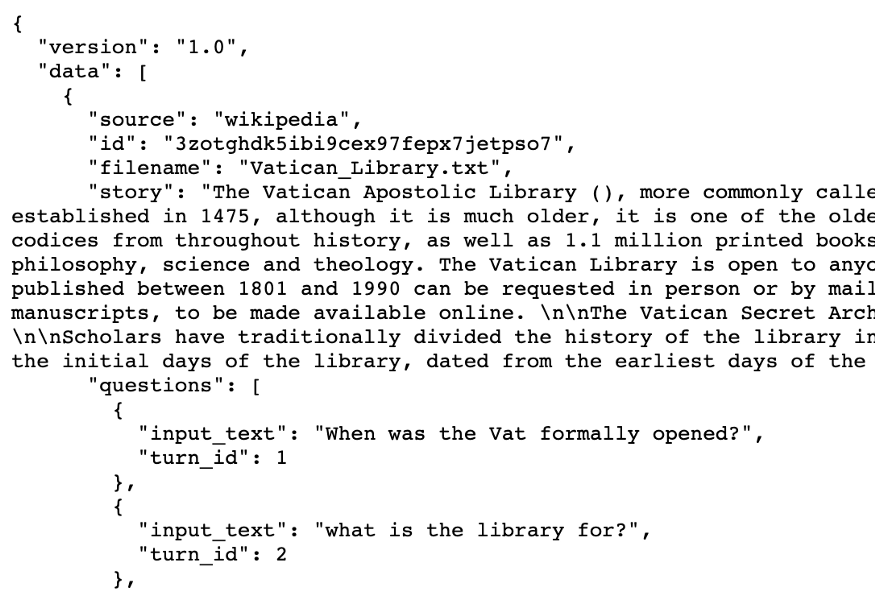

The JSON data has a lot of fields. For our purposes, we will use “story”, “input_text” from “questions” and “answers” and form our data frame.

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 6.8 MB 38.9 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#Installing Transformers

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

Data Loading from Stanford Website

In [ ]:
coqa = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json')
coqa.head()

,version,data
0,1,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."
2,1,"{'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn..."
3,1,"{'source': 'cnn', 'id': '3ewijtffvo7wwchw6rtya..."
4,1,"{'source': 'gutenberg', 'id': '3urfvvm165iantk..."


Data Cleaning
We will be dealing with the “data” column, so let’s just delete the “version” column.

In [ ]:
del coqa["version"]

In [ ]:
#required columns in our dataframe
cols = ["text","question","answer"]

#list of lists to create our dataframe
comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        comp_list.append(temp_list)

new_df = pd.DataFrame(comp_list, columns=cols) 
#saving the dataframe to csv file for further loading
new_df.to_csv("CoQA_data.csv", index=False)

Data Loading from Local CSV File

In [ ]:
data = pd.read_csv("CoQA_data.csv")
data.head()

,text,question,answer
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law"
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology"
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project


In [ ]:
print("Number of question and answers: ", len(data))

Number of question and answers:  108647


Building the Chatbot
The best part about using these pre-trained models is that you can load the model and its tokenizer in just two simple lines of code.  Isn’t it simply wow? For tasks like text classification, we need to fine-tune BERT on our dataset. But for question answering tasks, we can even use the already trained model and get decent results even when our text is from a completely different domain. To get decent results, we are using a BERT model which is fine-tuned on the SQuAD benchmark.
For our task, we will use the BertForQuestionAnswering class from the transformers library.

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Expect the downloading to take a couple of minutes as BERT-large is a really big model with 24 layers and 340M parameters, making it a 1.34GB model.

**Asking a Question**

Let’s randomly select a question number.

In [ ]:
random_num = np.random.randint(0,len(data))
question = data["question"][random_num]
text = data["text"][random_num]

Let’s tokenize the question and text as a pair.

In [ ]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 386 tokens.


To look at what our tokenizer is doing, let’s just print out the tokens and their IDs.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
who        2,040
else       2,842
was        2,001
in         1,999
the        1,996
room       2,282
?          1,029
[SEP]        102
chapter    3,127
ii         2,462
"          1,000
the        1,996
new        2,047
art        2,396
"          1,000
a          1,037
tall       4,206
,          1,010
fair       4,189
young      2,402
man        2,158
stood      2,768
in         1,999
the        1,996
small      2,235
al         2,632
##co       3,597
##ve       3,726
of         1,997
lady       3,203
swindon   22,350
'          1,005
s          1,055
drawing    5,059
-          1,011
room       2,282
,          1,010
with       2,007
his        2,010
eyes       2,159
fixed      4,964
upon       2,588
the        1,996
door       2,341
.          1,012
he         2,002
was        2,001
accurately  14,125
dressed    5,102
in         1,999
the        1,996
afternoon   5,027
ga        11,721
##rb      15,185
of         1,997
a          1,037
london     2,414
man        

#The Tokenizing
BERT has a unique way of processing the tokenized inputs. From the above screenshot, we can see two special tokens [CLS] and [SEP]. [CLS] token stands for classification and is there to represent sentence-level classification and is used when we are classifying. Another token used by BERT is [SEP]. It is used to separate the two pieces of text. You can see two [SEP] tokens in the above screenshots, one after the question and another after the text.
<br/>
<br/>
Apart from the “Token Embeddings”, BERT internally also uses “Segment Embeddings” and “Position Embeddings”. Segment embeddings help BERT in differentiating a question from the text. In practice, we use a vector of 0's if embeddings are from sentence 1 else a vector of 1’s if embeddings are from sentence 2.
<br/>
<br/>
Position embeddings help in specifying the position of words in the sequence. All these embeddings are fed to the input layer.
Transformers library can create segment embeddings on its own using PretrainedTokenizer.encode_plus(). But, we can even create our own. For that, we just need to specify a 0 or 1 for each token.

In [ ]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print("SEP token index: ", sep_idx)

#number of tokens in segment A (question) - this will be one more than the sep_idx as the index in Python starts from 0
num_seg_a = sep_idx+1
print("Number of tokens in segment A: ", num_seg_a)

#number of tokens in segment B (text)
num_seg_b = len(input_ids) - num_seg_a
print("Number of tokens in segment B: ", num_seg_b)

#creating the segment ids
segment_ids = [0]*num_seg_a + [1]*num_seg_b

#making sure that every input token has a segment id
assert len(segment_ids) == len(input_ids)

SEP token index:  8
Number of tokens in segment A:  9
Number of tokens in segment B:  377


Here is the output.

Let’s now feed this to our model.

In [ ]:
#token input_ids to represent the input and token segment_ids to differentiate our segments - question and text
output = model(torch.tensor([input_ids]),  token_type_ids=torch.tensor([segment_ids]))

Looking at the most probable start and end words and providing answers only if the end token is after the start token.

In [ ]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
# print the results
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))


Question:
Who else was in the room?

Answer:
Lady swindon ' s drawing - room , with his eyes fixed upon the door . he was accurately dressed in the afternoon ga ##rb of a london man about town , and carried in his hand , or rather in his hands , for they were crossed behind him , that hall - mark of western civilization - - a well - brushed , immaculate silk hat . neither in his clothes nor personal appearance was there any striking difference between him and the crowd of other young men who th ##rong ##ed the rooms.


Here, is our question and its answer.

Wow! BERT predicted the right answer. But, what’s this “##” in the reply? Keep on reading!

#BERT and wordpiece tokenization
BERT uses wordpiece tokenization. In BERT, rare words get broken down into subwords/pieces. Wordpiece tokenization uses ## to delimit tokens that have been split. An example of this: “Karin” is a common word so wordpiece does not split it. However, “Karingu” is a rare word so wordpiece split it into the words, “Karin” and “##gu”. 
<br/>
<br/>
Notice that it has added ## before gu to indicate that it is the second piece of the split word.
The idea behind using wordpiece tokenization is to reduce the size of the vocabulary which improves training performance. Consider the words, run, running, runner. Without wordpiece tokenization, the model has to store and learn the meaning of all three words independently. However, with wordpiece tokenization, each of the three words would be split into ‘run’ and the related ‘##SUFFIX’ (if any suffix at all — for example, “run”, “##ning”, “##ner”). 
<br/>
<br/>
Now, the model will learn the context of the word “run” and the rest of the meaning would be encoded in the suffix, which would be learned from other words with similar suffixes.
Interesting, right? We can reconstruct these words using the following simple code.

In [ ]:
answer = tokens[answer_start]
for i in range(answer_start+1, answer_end+1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]
    else:
        answer += " " + tokens[i]

In [ ]:
print(answer)

lady swindon ' s drawing - room , with his eyes fixed upon the door . he was accurately dressed in the afternoon garb of a london man about town , and carried in his hand , or rather in his hands , for they were crossed behind him , that hall - mark of western civilization - - a well - brushed , immaculate silk hat . neither in his clothes nor personal appearance was there any striking difference between him and the crowd of other young men who thronged the rooms


The above answer will now become easy to read
Let us now turn this question-answering process into a function for ease.

In [ ]:
def question_answer(question, text):
    
    #tokenize question and text as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)
    #number of tokens in segment A (question)
    num_seg_a = sep_idx+1
    #number of tokens in segment B (text)
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s for segment embeddings
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)
    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
    print("\nPredicted answer:\n{}".format(answer.capitalize()))

Let’s test this function out by using a text and question from our dataset.

In [ ]:
text = """New York (CNN) -- More than 80 Michael Jackson collectibles -- including the late pop star's 
famous rhinestone-studded glove from a 1983 performance -- were auctioned off Saturday, reaping a total $2
 million. Profits from the auction at the Hard Rock Cafe in New York's Times Square crushed pre-sale expectations
  of only $120,000 in sales. The highly prized memorabilia, which included items spanning the many stages of 
  Jackson's career, came from more than 30 fans, associates and family members, who contacted Julien's Auctions 
  to sell their gifts and mementos of the singer. Jackson's flashy glove was the big-ticket item of the night,
   fetching $420,000 from a buyer in Hong Kong, China. Jackson wore the glove at a 1983 performance during \"Motown 25,\"
    an NBC special where he debuted his revolutionary moonwalk. Fellow Motown star Walter \"Clyde\" Orange of the
     Commodores, who also performed in the special 26 years ago, said he asked for Jackson's autograph at the time, 
     but Jackson gave him the glove instead. "The legacy that [Jackson] left behind is bigger than life for me,\" 
     Orange said. \"I hope that through that glove people can see what he was trying to say in his music and what 
     he said in his music.\" Orange said he plans to give a portion of the proceeds to charity. Hoffman Ma, who bought
      the glove on behalf of Ponte 16 Resort in Macau, paid a 25 percent buyer's premium, which was tacked onto all 
      final sales over $50,000. Winners of items less than $50,000 paid a 20 percent premium."""
question = "Where was the Auction held?"
question_answer(question, text)
#original answer from the dataset
print("Original answer:\n", data.loc[data["question"] == question]["answer"].values[0])


Predicted answer:
Hard rock cafe in new york ' s times square
Original answer:
 Hard Rock Cafe


Now lets try it on a the notes from a doctor visit and see if it can corectly identify elemnts of the data.

In [ ]:
text = """Note 477 the patient came in suffering from coughing wheezing and 
swollen lymph nodes after a careful examination it became clear that he was 
suffering from severe Carcinoma Syndrome a very serious disease he was prescribed 
ten CC's of Prozac to help reduce the swelling and sent on his way will follow up in two weeks """
question = "What disease dose the patient have?"
question_answer(question, text)
#original answer from the dataset
print("Original question :")
print(question)


Predicted answer:
Severe carcinoma syndrome
Original question :
What disease dose the patient have?


Not bad at all. In fact, our BERT model gave a more detailed response.
Here, is a small function to test out how well BERT understands contexts. I just made the question answering process as a loop to play around with the model. 

In [ ]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")
while True:
    question_answer(question, text)
    
    flag = True
    flag_N = False
    
    while flag:
        response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        if response[0] == "Y":
            question = input("\nPlease enter your question: \n")
            flag = False
        elif response[0] == "N":
            print("\nBye!")
            flag = False
            flag_N = True
            
    if flag_N == True:
        break

And, the result

Please enter your text: 
The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula.   The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail.   In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online.   The Vatican Secret Archives were separated from the library at the beginning of the 17th century; they contain another 150,000 items.   Scholars have traditionally divided the history of the library into five periods, Pre-Lateran, Lateran, Avignon, Pre-Vatican and Vatican.   The Pre-Lateran period, comprising the initial days of the library, dated from the earliest days of the Church. Only a handful of volumes survive from this period, though some are very significant.

Please enter your question: 
When was the Vat formally opened?

Answer:
1475

Do you want to ask another question based on this text (Y/N)? Y

Please enter your question: 
what is the library for?

Answer:
Research library for history , law , philosophy , science and theology

Do you want to ask another question based on this text (Y/N)? Y

Please enter your question: 
for what subjects?

Answer:
History , law , philosophy , science and theology
Do you want to ask another question based on this text (Y/N)? N

Bye!

Voila! It works great! 🤗
I hope this article gave you a sense of how we can easily use a pre-trained model from the Hugging Face Transformer library and perform our task. If you want to look at the code as a notebook file, here is the Github link.
References:

https://huggingface.co/

https://arxiv.org/pdf/1810.04805.pdf

https://arxiv.org/pdf/1808.07042.pdf

https://github.com/google-research/bert/issues/44